In [1]:
import numpy as np
import csv
import glob
import os.path
from os import path
from datetime import datetime

In [81]:
# The basic CSV instrument. We'll abstract this later when we need it
class FileInstrument:
    def __init__(self, filename, load=True):
        self.datetime_format = '%d-%b-%Y'
        self.column_names = ['day', 'month', 'year', 'open', 'high', 'low', 'close', 'volume', 'forward_returns']
        self.column_set = set(self.column_names)
        
        self.data = None
        
        if load:
            self.load_file(filename)
        
    def load_file(self, filename):
        with open(filename) as f:
            item = []
            reader = csv.reader(f)
            for row in reader:
                _row = self.format_row(*row)
                item.append(_row)
                
        item = np.array(item)
        returns = np.expand_dims(np.diff(item[:,-2], append=item[:,-2][-1]), axis=1)
        
        items_with_returns = np.hstack((item, returns))
        self.data = items_with_returns
        
    def format_row(self, *args):
        date = datetime.strptime(args[0], self.datetime_format)
        o = float(args[1])
        h = float(args[2])
        l = float(args[3])
        c = float(args[4])
        v = int(args[5])

        return [date.day, date.month, date.year, o, h, l, c, v]
    
    def attach_feature(self, feature, name):
        self.column_set.add(name) # this will fail if the feature already exists
        self.column_names.append(name)
        
        f = np.expand_dims(feature, axis=1)
        self.data = np.hstack((self.data, f))
    
    def __getitem__(self, key):
        if type(key) == str:
            idx = self.column_names.index(key)
            return self.data[:,idx]
        
        return self.data.__getitem__(key)

    def __repr__(self):
        return self.data.__repr__()

In [82]:
luv = FileInstrument('../../Developer/Data/prices/NYSE/LUV.csv')

In [83]:
luv

array([[ 3.00000e+00,  1.00000e+00,  2.00000e+03, ...,  1.05800e+01,
         3.27780e+06, -2.90000e-01],
       [ 4.00000e+00,  1.00000e+00,  2.00000e+03, ...,  1.02900e+01,
         4.70205e+06, -4.00000e-02],
       [ 5.00000e+00,  1.00000e+00,  2.00000e+03, ...,  1.02500e+01,
         3.43290e+06, -4.00000e-02],
       ...,
       [ 7.00000e+00,  1.00000e+00,  2.02000e+03, ...,  5.42900e+01,
         2.99920e+06,  8.00000e-02],
       [ 8.00000e+00,  1.00000e+00,  2.02000e+03, ...,  5.43700e+01,
         4.10300e+06, -7.00000e-02],
       [ 9.00000e+00,  1.00000e+00,  2.02000e+03, ...,  5.43000e+01,
         3.85080e+06,  0.00000e+00]])

In [84]:
luv[0]

array([ 3.0000e+00,  1.0000e+00,  2.0000e+03,  1.0790e+01,  1.0910e+01,
        1.0460e+01,  1.0580e+01,  3.2778e+06, -2.9000e-01])

In [85]:
luv[:,0]

array([3., 4., 5., ..., 7., 8., 9.])

In [86]:
luv['day']

array([3., 4., 5., ..., 7., 8., 9.])

In [87]:
import talib

In [88]:
d = np.diff(luv['close'], prepend=luv['close'][0])

In [89]:
luv.attach_feature(d, 'back_returns')

In [91]:
luv['back_returns']

array([ 0.  , -0.29, -0.04, ...,  0.16,  0.08, -0.07])

In [92]:
d

array([ 0.  , -0.29, -0.04, ...,  0.16,  0.08, -0.07])

In [93]:
def run_monte_single(asset, idx, samples=1000, simulations=1000):
    returns = asset[:,-1][idx]
    mcs = np.stack([np.cumsum(np.random.choice(returns, samples)) for i in range(simulations)])
    return mcs

In [95]:
mc = run_monte_single(luv, luv['back_returns'] > talib.EMA(luv['back_returns']))

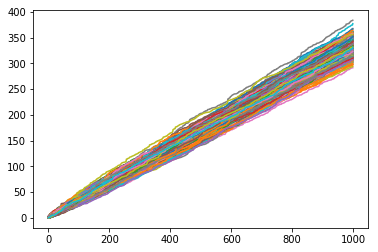

In [98]:
import matplotlib.pyplot as plt
plt.plot(mc.T)